[View in Colaboratory](https://colab.research.google.com/github/aniquetahir/Colaboratory/blob/master/SentimentAnalysis.ipynb)

# Objective Guide to Recurrent Neural Networks

This is a short to-the-point hands on guide to recurrent neural networks. For the purpose of demonstration, I use sentiment analysis as the use case. The principles applied, however, can be used for a number of tasks.

## Prerequisites
- You must have basic familiarity with data analysis
- You should be familiar with the fundamentals behind ANN



In [3]:
%%html 
<b style='color:red;'>Please enable GPU for the runtime: Runtime->Change Runtime Type->Hardware Accelerator->GPU</b>


## Precursors
- Install Keras
- Install Bokeh for visualizations
- Download the training dataset
- Import Keras Model, Layers

In [5]:
%%bash
apt install graphviz
pip install keras
pip install bokeh
pip install git+https://github.com/tla/ipython-hierarchymagic

  Cloning https://github.com/tla/ipython-hierarchymagic to /tmp/pip-req-build-k66zruon
  Running setup.py bdist_wheel for ipython-hierarchymagic: started
  Running setup.py bdist_wheel for ipython-hierarchymagic: finished with status 'done'
  Stored in directory: /tmp/pip-ephem-wheel-cache-urg_0b31/wheels/32/77/29/9bb9c3340e84bcdaa481575d1d18e60857fc184ba89a34e5f6
Successfully built ipython-hierarchymagic


In [0]:
%load_ext hierarchymagic

### Test Bokeh visualizations


In [0]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook

In [66]:
output_notebook()

Loading BokehJS ...

### Sentiment Analysis Data
We will use the IMDB dataset for this experiment

In [4]:
import numpy as np
import pandas as pd
import keras

Using TensorFlow backend.


In [0]:
from keras.datasets import imdb

In [0]:
#@title ### Dataset Parameters
#@markdown ---
#@markdown #### Number of words to use in classification
num_classification_words = 20000 #@param {type: "number"}
#@markdown #### The word limit for each entry
words_limit = 100 #@param {type: "number"}



In [8]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_classification_words)

17465344/17464789 [==============================] - 2s 0us/step


#### Data Preprocessing
Our RNN will take sequences of constant length. In our case this length is the `words_limit`


In [0]:
from keras.preprocessing import sequence

In [10]:
x_train_seq = sequence.pad_sequences(x_train, maxlen=words_limit)
x_test_seq = sequence.pad_sequences(x_test, maxlen=words_limit)

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (25000, 100)
test shape: (25000, 100)


#### What kind of Data is this?
The IMDB data that we just downloaded consists of reviews for movies. The labels tell us whether the sentiment for the review is positive or negative.

After inspecting the data, you might find that the review data is just a list of numbers. This is because each word is enumerated as a number so that our solution can recognize it and assign it a place.

Since each review consists of a variable number of words, we use `sequence.pad_sequences` to pad/truncate each review to a constant length.

In [0]:
from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, Activation, Input, LSTM, GRU

## RNN Sentiment Analysis
Here we create an RNN to analyze sentiments


###What is an RNN?
An RNN cell is a node in a neural network which is connected to itself. The output of the cell serves as the input to the cell. Consider the case of a sentence in out IMDB review example. Here each review is represented by a hundred words. In the case of an RNN. The first word is the first input to this cell. The output of this cell is used as the input to the cell again in addition to the second word and so forth till we reach the last word. Finally the output might be used in further layers to produce an output which represents the sentiment.

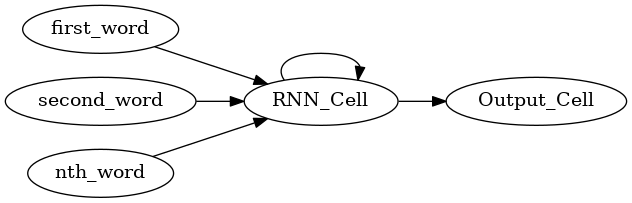

In [19]:
%%dot
digraph G {
    rankdir=LR;
    first_word -> RNN_Cell;
    second_word -> RNN_Cell;
    nth_word -> RNN_Cell;
    RNN_Cell -> RNN_Cell;
    RNN_Cell -> Output_Cell;
}

**Unfolded RNN**

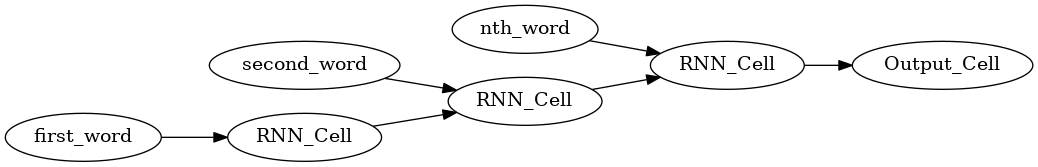

In [24]:
%%dot
digraph G {
    rankdir=LR;
    node1 [label="RNN_Cell"];
    node2 [label="RNN_Cell"];
    node3 [label="RNN_Cell"];
    first_word -> node1;
    second_word -> node2;
    nth_word -> node3;
    node1 -> node2;
    node2 -> node3;
    node3 -> Output_Cell;
}

In [0]:
rnn_input = Input(shape=(100,))
embedding = Embedding(num_classification_words, 128, input_length=words_limit)(rnn_input)
simple_rnn = SimpleRNN(128)(embedding)
dropout = Dropout(0.4)(simple_rnn)
dense = Dense(1)(dropout)
activation = Activation('sigmoid')(dense)
model = Model(rnn_input, activation)


In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 2,593,025
Trainable params: 2,593,025
Non-trainable params: 0
_________________________________________________________________


In [0]:
# from keras.metrics import categorical_accuracy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
model.fit(x_train_seq, y_train, batch_size=32, epochs=3, validation_data=(x_test_seq, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 75s 3ms/step - loss: 0.6302 - acc: 0.6261 - val_loss: 0.4743 - val_acc: 0.7806
Epoch 2/3
25000/25000 [==============================] - 75s 3ms/step - loss: 0.4538 - acc: 0.8017 - val_loss: 0.4607 - val_acc: 0.7996
Epoch 3/3
25000/25000 [==============================] - 74s 3ms/step - loss: 0.5124 - acc: 0.7514 - val_loss: 0.6627 - val_acc: 0.5831


## LSTM Sentiment Analysis

###What is an LSTM?
An LSTM (Long Short Term Memory) Cell, as the name implies, is capable of storing long and short term dependencies.

Consider the following two sentences:
- Cats are good
- Cats are animals. Cats are very popular on the internet. This means that they are good.

Both of the sentences reflect a positive sentiment. However, the distance between the subject and adjective is different in both the sentences. If we use a simple RNN. This type of relationship is impossible to represent(assuming we have a limited number of cells and training examples).

LSTM's are designed like IC's. They have gates(input, forget, output) that store long and short term dependencies. This makes it easier to process this sort of use case. 

In [42]:
lstm_input = Input(shape=(100,))
embedding = Embedding(num_classification_words, 128, input_length=words_limit)(lstm_input)
simple_lstm = LSTM(128)(embedding)
dropout = Dropout(0.4)(simple_lstm)
dense = Dense(1)(dropout)
activation = Activation('sigmoid')(dense)
model = Model(lstm_input, activation)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0         
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train_seq, y_train, batch_size=32, epochs=3, validation_data=(x_test_seq, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 280s 11ms/step - loss: 0.4162 - acc: 0.8048 - val_loss: 0.3377 - val_acc: 0.8501
Epoch 2/3
25000/25000 [==============================] - 278s 11ms/step - loss: 0.2356 - acc: 0.9079 - val_loss: 0.3849 - val_acc: 0.8462
Epoch 3/3
25000/25000 [==============================] - 279s 11ms/step - loss: 0.1445 - acc: 0.9468 - val_loss: 0.4448 - val_acc: 0.8381


In [45]:
score, acc = model.evaluate(x_test_seq, y_test, batch_size=32)
print("Score: ",score)
print("Accuracy: ",acc)

25000/25000 [==============================] - 57s 2ms/step
Score:  0.44481423910140994
Accuracy:  0.83812


## GRU Sentiment Analysis


### What is GRU?
GRU is a simplified version of LSTM. Instead of three gates. It has two gates (reset and update). Because of their simplicity GRU's sometimes give better results than LSTM's but not always. It is up to the data scientist to figure out what to use.

In [48]:
gru_input = Input(shape=(100,))
embedding = Embedding(num_classification_words, 128, input_length=words_limit)(gru_input)
gru = GRU(128)(embedding)
dropout = Dropout(0.4)(gru)
#dense_middle = Dense(128)(dropout)
#dropout2 = Dropout(0.4)(dense_middle)
dense = Dense(1)(dropout)
activation = Activation('sigmoid')(dense)
model = Model(gru_input, activation)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
_________________________________________________________________
activation_9 (Activation)    (None, 1)                 0         
Total params: 2,658,817
Trainable params: 2,658,817
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train_seq, y_train, batch_size=32, epochs=3, validation_data=(x_test_seq, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 228s 9ms/step - loss: 0.4450 - acc: 0.7861 - val_loss: 0.3589 - val_acc: 0.8449
Epoch 2/3
25000/25000 [==============================] - 225s 9ms/step - loss: 0.2404 - acc: 0.9056 - val_loss: 0.3471 - val_acc: 0.8571
Epoch 3/3
25000/25000 [==============================] - 227s 9ms/step - loss: 0.1342 - acc: 0.9524 - val_loss: 0.4543 - val_acc: 0.8454


In [51]:
score, acc = model.evaluate(x_test_seq, y_test, batch_size=32)
print("Score: ",score)
print("Accuracy: ",acc)

25000/25000 [==============================] - 47s 2ms/step
Score:  0.45425059258461
Accuracy:  0.8454


In [52]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [72]:
p = figure(title="Loss History", x_axis_label='Time', y_axis_label='Loss')
range(len(history.history['val_loss']))
p.line(range(len(history.history['val_loss'])), history.history['val_loss'], 
       legend="Val. Loss", line_width=2, line_color='orange')
p.line(range(len(history.history['loss'])), history.history['loss'], 
       legend="Loss", line_width=2, line_color='blue')

bokeh.models.renderers.GlyphRenderer(
    id='8099ef6a-d42a-4a34-859a-30b506ac12c8',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='1de9ba15-90a1-49ef-8052-1657d087b149',
        callback=None,
        data={'x': [0, 1, 2],
         'y': [0.4449998366355896, 0.24043350867271424, 0.13423719838202]},
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        selected=bokeh.models.selections.Selection(
            id='5bec04ca-6789-4b5a-8823-f75746339b2a',
            indices=[],
            js_event_callbacks={},
            js_property_callbacks={},
            line_indices=[],
            multiline_indices={},
            name=None,
            subscribed_events=[],
            tags=[]),
        selection_policy=bokeh.models.selections.UnionRenderers(
            id='ff8f6bd6-a87b-4055-96dc-6d9b1c3539e3',
            js_event_callbacks={},
            js_property_callbacks={},
            name=None,
            subscribed_events=[],
            tags=[]),
        subscribed_events=[],
        tags=[]),
    glyph=bokeh.models.glyphs.Line(
        id='bd3adcda-80ba-4d10-94ff-78917cf84e1f',
        js_event_callbacks={},
        js_property_callbacks={},
        line_alpha=1.0,
        line_cap='butt',
        line_color='blue',
        line_dash=[],
        line_dash_offset=0,
        line_join='bevel',
        line_width=2,
        name=None,
        subscribed_events=[],
        tags=[],
        x={'field': 'x'},
        y={'field': 'y'}),
    hover_glyph=None,
    js_event_callbacks={},
    js_property_callbacks={},
    level='glyph',
    muted=False,
    muted_glyph=None,
    name=None,
    nonselection_glyph=bokeh.models.glyphs.Line(
        id='a31cd7f4-e38e-4e4e-9399-da619dd4b9af',
        js_event_callbacks={},
        js_property_callbacks={},
        line_alpha=0.1,
        line_cap='butt',
        line_color='#1f77b4',
        line_dash=[],
        line_dash_offset=0,
        line_join='bevel',
        line_width=2,
        name=None,
        subscribed_events=[],
        tags=[],
        x={'field': 'x'},
        y={'field': 'y'}),
    selection_glyph=None,
    subscribed_events=[],
    tags=[],
    view=bokeh.models.sources.CDSView(
        id='68c97f9c-708f-4f39-87ee-f824c3a37a9d',
        filters=[],
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        source=bokeh.models.sources.ColumnDataSource(
            id='1de9ba15-90a1-49ef-8052-1657d087b149',
            callback=None,
            data={'x': [0, 1, 2],
             'y': [0.4449998366355896, 0.24043350867271424, 0.13423719838202]},
            js_event_callbacks={},
            js_property_callbacks={},
            name=None,
            selected=bokeh.models.selections.Selection(
                id='5bec04ca-6789-4b5a-8823-f75746339b2a',
                indices=[],
                js_event_callbacks={},
                js_property_callbacks={},
                line_indices=[],
                multiline_indices={},
                name=None,
                subscribed_events=[],
                tags=[]),
            selection_policy=bokeh.models.selections.UnionRenderers(
                id='ff8f6bd6-a87b-4055-96dc-6d9b1c3539e3',
                js_event_callbacks={},
                js_property_callbacks={},
                name=None,
                subscribed_events=[],
                tags=[]),
            subscribed_events=[],
            tags=[]),
        subscribed_events=[],
        tags=[]),
    visible=True,
    x_range_name='default',
    y_range_name='default')

In [73]:
output_notebook()
show(p)

Loading BokehJS ...

In [76]:
p = figure(title="Accuracy History", x_axis_label='Time', y_axis_label='Loss')
p.line(range(len(history.history['val_acc'])), history.history['val_acc'], 
       legend="Val. Acc", line_width=2, line_color='orange')
p.line(range(len(history.history['acc'])), history.history['acc'], 
       legend="Acc", line_width=2, line_color='blue')
output_notebook()
show(p)

Loading BokehJS ...

#### The numbers! What do they mean?
Our validation accuracy is going down but our model accuracy is going up. This is an example of overfitting. Since the change is negligible, we can ignore this. We have just designed a sentiment analysis system with ~0.84 accuracy. 

## Conclusion
RNN and its kind are a great way to do sentiment analysis with minimum amount of workflow. This notebook uses preprocessed imdb data so in a real life use case, preprocessing steps need to be taken into account. This approach can be extended to other problems as well!